In [3]:
import os, json
import importlib
import torch
import torch_geometric

# deprecated in torch_geometric 2.0
try:
    from torch_geometric.loader import DataLoader
except:
    from torch_geometric.data import DataLoader

import hydragnn

import voronoi_utils_gin as voronoi_utils
importlib.reload(voronoi_utils)

import torch_geometric.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
%matplotlib inline

dataset = voronoi_utils.VoronoiNet(root='.',force_reload=True) # 

Processing...
Done!


In [4]:
dataset.print_summary()

VoronoiNet (#graphs=400):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     31.8 |    177.9 |
| std        |     64.3 |    366.2 |
| min        |      2   |      2   |
| quantile25 |      5   |     20   |
| median     |      6   |     30   |
| quantile75 |     21   |    128   |
| max        |    328   |   1850   |
+------------+----------+----------+


In [5]:
# shuffled_dataset, perm = dataset.shuffle(return_perm=True)

In [7]:
perm = torch.tensor([319,  12,  81, 137, 351,  34, 103, 258, 322, 118, 307, 252, 284, 293,
        163, 291,  21, 201, 312, 187, 349, 246, 235, 203, 101,  83, 194, 129,
        133, 272, 158, 124, 317, 268,  37, 172,  14, 162, 105, 113, 279, 354,
          8, 393, 170,  52, 396,  86, 374, 225,   6, 372, 238,  44, 224,  19,
        320,  54, 237, 245, 115, 278, 242, 205, 303, 357,  41, 256, 298, 375,
        220,  65, 111,  94, 324, 292, 335, 161,  95, 380, 151, 202, 346, 231,
        149, 325, 333, 119,  42,  99, 106, 207, 355, 330, 184, 281, 146, 232,
          3, 369, 306, 261, 344, 358, 204, 387, 309, 211,  63, 222, 361, 301,
        260, 288, 345,  46,   9, 388, 155,  64, 153, 247, 191,  61,  36, 287,
        255, 141, 316, 348, 125, 399,  70, 311,  53,  38,  15, 304, 365,  32,
         10, 290, 336, 159,  79, 389, 223, 285,  20, 126, 264, 175, 193, 167,
        107, 171, 244, 189, 134,  91, 283, 179, 318, 230,  39,  25, 112,  59,
         11, 152, 249, 366, 228, 371, 182, 381, 394, 132, 385, 343, 271, 254,
         78, 305, 367, 282, 377, 362,  48, 120, 337, 160, 145,  97,  23,  77,
        199, 379,  87, 269, 263, 192, 378,  50, 323, 174, 350,  71,  93, 262,
        383, 259, 123,  85, 390, 135, 314, 164,  28, 190,  26, 294,  45, 173,
        197,   1, 110,  31, 215, 275, 327, 143, 116, 217, 154, 328, 196, 214,
         67, 286,   5,  96, 178, 165, 136, 313, 347,   7,  76, 157, 310, 382,
         74,  75,  90, 195, 156, 329, 338,  49,  68, 121, 176, 359, 188, 186,
        147,  92, 169,  47, 257, 168, 243, 297,  89, 138, 239,   2,  84, 114,
        332, 180, 397, 208,  66, 300, 128,  18, 229, 295, 226, 331,  29, 276,
        227, 251, 392, 117, 360,  55, 221,  17, 148, 363, 206,  40, 209, 341,
        100,  57, 364, 368, 108, 308,  27, 373, 386,  62, 102, 236,  98, 200,
        130, 342, 289, 166, 321,  16, 139, 270, 240, 280, 150, 127,  33,  22,
         82, 233, 198, 241,  73, 299, 250, 326,  88, 266, 109, 273,  56,  35,
         30, 177, 210, 356,  58, 185, 144, 140, 265,  80, 183,  51,   0,   4,
         69, 104, 181,  72, 218, 142, 395, 296, 253,  60, 340, 353, 398, 339,
         24, 219, 277, 315, 352, 370, 376, 391, 274, 234, 131, 248, 334, 216,
        122, 213,  43, 384, 212,  13, 302, 267])
shuffled_dataset = dataset.index_select(perm)

In [8]:
data = shuffled_dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')
data

Dataset: VoronoiNet(400)
---------------
Number of graphs: 400
Number of nodes: 5
Number of features: 14
Number of classes: 399

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


/home/ecalisk1/anaconda3/envs/py311/lib/python3.11/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


Data(x=[5, 14], y=[1], pos=[5, 2], edge_index=[2, 20])

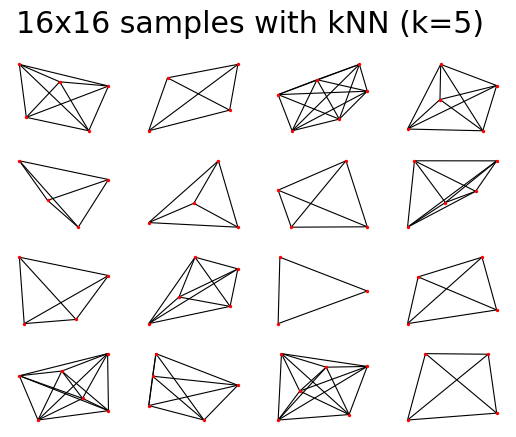

In [13]:
fig, ax = plt.subplots(4,4)
#fig.suptitle('Example graphs with radius (r=5)')
fig.suptitle('16x16 samples with kNN (k=5)')

k = 400

for i, data in enumerate(dataset[k-16:k]): 
    # Calculate color (green if correct, red otherwise)
    #out = gcn(data.x, data.edge_index, data.batch)
    #color = "green" if out.argmax(dim=1) == data.y else "red"
    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    #G = to_networkx(data,edge_attrs=data.edge_attr[:,0], to_undirected=True)
    G = nx.Graph()

    node_positions = data.pos
    
    for i, pos in enumerate(node_positions):
        G.add_node(i, pos=pos)
    G.add_nodes_from(range(data.num_nodes))
    G.add_edges_from(data.edge_index.T.tolist())

    # Save edge attributes to G
    #for i, (u, v) in enumerate(G.edges()):
    #    G[u][v]['attribute'] = data.edge_attr[i].tolist()
    nx.draw_networkx(G,
                     pos=node_positions,
                    #pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=2,
                    node_color="red",
                    width=0.8,
                    ax=ax[ix]
                    )

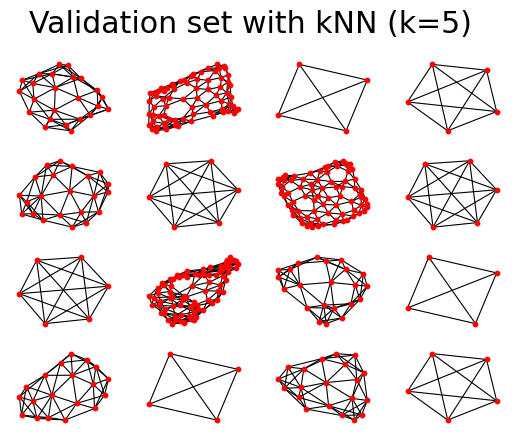

In [10]:
fig, ax = plt.subplots(4,4)
#fig.suptitle('Example graphs with kNN (k=5)')
fig.suptitle('Validation set with kNN (k=5)')

for i, data in enumerate(shuffled_dataset[308:324]):
    # Calculate color (green if correct, red otherwise)
    #out = gcn(data.x, data.edge_index, data.batch)
    #color = "green" if out.argmax(dim=1) == data.y else "red"
    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color="red",
                    width=0.8,
                    ax=ax[ix]
                    )

In [13]:
# Set this path for output.
try:
    os.environ["SERIALIZED_DATA_PATH"]
except:
    os.environ["SERIALIZED_DATA_PATH"] = os.getcwd()

# num_samples = 64

# Configurable run choices (JSON file that accompanies this example script).
#filename = os.path.join(os.path.dirname(os.path.abspath(__file__)), "qm9.json")

# filename = os.path.join(os.getcwd(), "voronoi_PNA.json")
filename = os.path.join(os.getcwd(), "voronoi_gin.json")
with open(filename, "r") as f:
    config = json.load(f)
verbosity = config["Verbosity"]["level"]
var_config = config["NeuralNetwork"]["Variables_of_interest"]

# Always initialize for multi-rank training.
world_size, world_rank = hydragnn.utils.setup_ddp()

log_name = "gin_100ep_1e-4_pc90_b4_k5_hd64_head_32_edge_shuffled"
# Enable print to log file.
hydragnn.utils.setup_log(log_name)

# Use built-in torch_geometric dataset.
# Filter function above used to run quick example.
# NOTE: data is moved to the device in the pre-transform.
# NOTE: transforms/filters will NOT be re-run unless the qm9/processed/ directory is removed.

# dataset = torch_geometric.datasets.QM9(
#     root="dataset/qm9", pre_transform=qm9_pre_transform, pre_filter=qm9_pre_filter
# )
train, val, test = hydragnn.preprocess.split_dataset(
    shuffled_dataset, config["NeuralNetwork"]["Training"]["perc_train"], False
)
(train_loader, val_loader, test_loader,) = hydragnn.preprocess.create_dataloaders(
    train, val, test, config["NeuralNetwork"]["Training"]["batch_size"]
)

config = hydragnn.utils.update_config(config, train_loader, val_loader, test_loader)

model = hydragnn.models.create_model_config(
    config=config["NeuralNetwork"],
    verbosity=verbosity,
)
model = hydragnn.utils.get_distributed_model(model, verbosity)

learning_rate = config["NeuralNetwork"]["Training"]["Optimizer"]["learning_rate"]
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, min_lr=0.000001
)

0: Using CPU
0: Using CPU


Distributed data parallel: gloo master at 127.0.0.1:8890


In [14]:
# Run training with the given model and Voronoi dataset.
writer = hydragnn.utils.get_summary_writer(log_name)
hydragnn.utils.save_config(config, log_name)

hydragnn.train.train_validate_test(
    model,
    optimizer,
    train_loader,
    val_loader,
    test_loader,
    writer,
    scheduler,
    config["NeuralNetwork"],
    log_name,
    verbosity,
    create_plots=config["Visualization"]["create_plots"],
)

0: Epoch: 00, Train Loss: 0.75449342, Val Loss: 0.62925720, Test Loss: 0.62382531
0: Tasks Loss: [0.7544934153556824]
0: Epoch: 01, Train Loss: 0.37699419, Val Loss: 0.14717910, Test Loss: 0.14292833
0: Tasks Loss: [0.37699419260025024]
0: Epoch: 02, Train Loss: 0.02704481, Val Loss: 0.01057884, Test Loss: 0.00520640
0: Tasks Loss: [0.027044810354709625]
0: Epoch: 03, Train Loss: 0.00301240, Val Loss: 0.00438400, Test Loss: 0.00269188
0: Tasks Loss: [0.003012401983141899]
0: Epoch: 04, Train Loss: 0.00196340, Val Loss: 0.00176816, Test Loss: 0.00204213
0: Tasks Loss: [0.001963401446118951]
0: Epoch: 05, Train Loss: 0.00205840, Val Loss: 0.00157524, Test Loss: 0.00117180
0: Tasks Loss: [0.002058402867987752]
0: Epoch: 06, Train Loss: 0.00120894, Val Loss: 0.00089764, Test Loss: 0.00110371
0: Tasks Loss: [0.001208936097100377]
0: Epoch: 07, Train Loss: 0.00122088, Val Loss: 0.00127962, Test Loss: 0.00110678
0: Tasks Loss: [0.0012208794942125678]
0: Epoch: 08, Train Loss: 0.00101113, Val 

In [15]:
config

{'Verbosity': {'level': 1},
 'NeuralNetwork': {'Architecture': {'model_type': 'GIN',
   'radius': 7,
   'max_neighbours': 5,
   'periodic_boundary_conditions': False,
   'hidden_dim': 64,
   'num_conv_layers': 6,
   'output_heads': {'graph': {'num_sharedlayers': 4,
     'dim_sharedlayers': 32,
     'num_headlayers': 5,
     'dim_headlayers': [256, 128, 64, 32, 32]}},
   'task_weights': [1.0],
   'output_dim': [1],
   'output_type': ['graph'],
   'num_nodes': 5,
   'input_dim': 14,
   'pna_deg': None,
   'num_gaussians': None,
   'num_filters': None,
   'envelope_exponent': None,
   'num_after_skip': None,
   'num_before_skip': None,
   'basis_emb_size': None,
   'int_emb_size': None,
   'out_emb_size': None,
   'num_radial': None,
   'num_spherical': None,
   'edge_dim': None,
   'equivariance': False,
   'freeze_conv_layers': False,
   'initial_bias': None,
   'activation_function': 'relu',
   'SyncBatchNorm': False},
  'Variables_of_interest': {'output_dim': [1],
   'input_node_featu

In [16]:
verbosity

1

In [17]:
test_error, tasks_error, true_values, predicted_values = hydragnn.train.test(test_loader, model,verbosity=2)

Test: 100%|██████████| 5/5 [00:00<00:00, 585.29it/s]


In [19]:
true_values[0]

tensor([0.8282, 0.8323, 0.8076, 0.8206, 0.8232, 0.8040, 0.8370, 0.8331, 0.8917,
        0.8643, 0.8469, 0.8271, 0.8475, 0.8465, 0.8582, 0.8335, 0.8540])

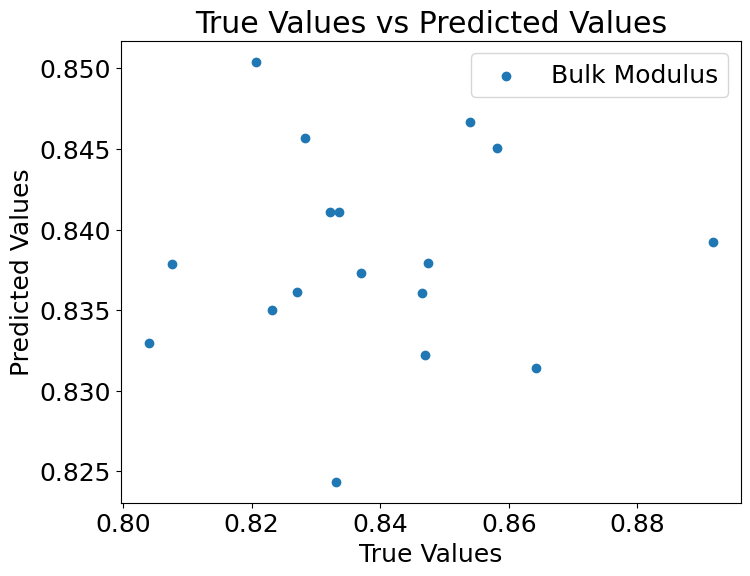

In [20]:
true_values_l = [t.numpy() for t in true_values]
predicted_values_l = [p.numpy() for p in predicted_values]


plt.figure(figsize=(8, 6))
#for i in range(len(true_values)):
#    plt.scatter(true_values[i], predicted_values[i], label=f'Task {i+1}')
plt.scatter(true_values[0], predicted_values[0], label=f'Bulk Modulus')



plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs Predicted Values')
plt.legend()
plt.show()